In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [95]:
df_train = pd.read_csv('../input/train.csv', encoding='utf-8')
df_train['id'] = df_train['id'].apply(str)

df_test = pd.read_csv('../input/test.csv', encoding='utf-8')
df_test['test_id'] = df_test['test_id'].apply(str)

df_all = pd.concat((df_train, df_test))
df_all['question1'].fillna('xzxzxz zxzxzx', inplace=True)
df_all['question2'].fillna('xzxzxz zxzxzx', inplace=True)

counts_vectorizer = CountVectorizer(max_features=20000-1).fit(
    itertools.chain(df_all['question1'], df_all['question2']))

other_index = len(counts_vectorizer.vocabulary_)

In [96]:
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

import keras.layers as lyr
from keras.models import Model

In [97]:
import keras
keras.__version__

'2.0.3'

In [98]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

def create_padded_seqs(texts, max_len=10):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)

In [99]:
# df_all = df_all.sample(1000) # Just for debugging

In [100]:
print df_all[df_all['id'].notnull()].head()['question1'].str.split().str.len()

0    14
1     8
2    14
3    11
4    13
Name: question1, dtype: int64


In [101]:
sorted(counts_vectorizer.vocabulary_.items(), key=lambda x: x[1])[:10]

[(u'00', 0),
 (u'000', 1),
 (u'01', 2),
 (u'018', 3),
 (u'02', 4),
 (u'03', 5),
 (u'04', 6),
 (u'05', 7),
 (u'06', 8),
 (u'060', 9)]

In [102]:
create_padded_seqs(df_all[df_all['id'].notnull()].head()['question1'])

array([[ 3049, 17111,  8129, 18160,  9562,  9100, 16195, 11160,  9100,
         9172],
       [    0, 19571,  9659, 17958, 17176, 12650, 10208, 10207, 19999,
         5451],
       [ 9148, 17958, 16857, 12650, 12039,  9478,  4295, 19592, 18933,
        19353],
       [    0, 19620,  1252, 11428, 19135, 10797,  8729,  3146, 16725,
         9701],
       [ 9100, 19460, 19999, 17375, 15690, 11496,  1355,  3231,  5431,
        12991]], dtype=int32)

In [103]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(create_padded_seqs(df_all[df_all['id'].notnull()]['question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.3, random_state=1989)

In [104]:
import tensorflow
tensorflow.__version__

'1.0.1'

In [83]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer = lyr.LSTM(128, activation='relu')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(64, activation='sigmoid')(merge_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
input_6 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
embedding_3 (Embedding)          (None, 10, 100)       1000000                                      
____________________________________________________________________________________________________
lstm_3 (LSTM)                    (None, 512)           1255424                                      
___________________________________________________________________________________________

In [118]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 100)
seq_embedding_layer = lyr.LSTM(128, activation='relu')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])
concat_layer = lyr.concatenate([merge_layer, seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(64, activation='sigmoid')(concat_layer)  # merge_layer)
dense1_layer = lyr.Dropout(0.3)(dense1_layer)
ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (None, 10)            0                                            
____________________________________________________________________________________________________
input_10 (InputLayer)            (None, 10)            0                                            
____________________________________________________________________________________________________
embedding_5 (Embedding)          (None, 10, 100)       2000000                                      
____________________________________________________________________________________________________
lstm_5 (LSTM)                    (None, 128)           117248                                       
___________________________________________________________________________________________

In [119]:
%%time
model.fit([X1_train, X2_train], y_train, 
          validation_data=([X1_val, X2_val], y_val), 
          batch_size=512, epochs=10, verbose=1)

Train on 283003 samples, validate on 121287 samples
Epoch 1/10
283003/283003 [==============================] - 30s - loss: 0.5482 - val_loss: 0.4998
Epoch 2/10
283003/283003 [==============================] - 29s - loss: 0.4717 - val_loss: 0.4740
Epoch 3/10
283003/283003 [==============================] - 29s - loss: 0.4258 - val_loss: 0.4642
Epoch 4/10
283003/283003 [==============================] - 29s - loss: 0.3816 - val_loss: 0.4596
Epoch 5/10
283003/283003 [==============================] - 29s - loss: 0.3387 - val_loss: 0.4786
Epoch 6/10
283003/283003 [==============================] - 29s - loss: 0.2992 - val_loss: 0.4925
Epoch 7/10
283003/283003 [==============================] - 29s - loss: 0.2647 - val_loss: 0.5069
Epoch 8/10
283003/283003 [==============================] - 29s - loss: 0.2340 - val_loss: 0.5432
Epoch 9/10
283003/283003 [==============================] - 29s - loss: 0.2069 - val_loss: 0.5784
Epoch 10/10
283003/283003 [==============================] - 29s -

In [120]:
features_model = Model([input1_tensor, input2_tensor], concat_layer)  # merge_layer)
features_model.compile(loss='mse', optimizer='adam')

In [121]:
F_train = features_model.predict([X1_train, X2_train], batch_size=128)
F_val = features_model.predict([X1_val, X2_val], batch_size=128)

In [122]:
import xgboost as xgb

In [123]:
dTrain = xgb.DMatrix(F_train, label=y_train)
dVal = xgb.DMatrix(F_val, label=y_val)

In [131]:
%%time
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 9,
    'subsample': 0.9,
    'colsample_bytree': 1 / F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}
bst = xgb.train(xgb_params, dTrain, 10000,  [(dTrain,'train'), (dVal,'val')], 
                verbose_eval=100, early_stopping_rounds=1000)

[0]	train-logloss:0.649996	val-logloss:0.658549
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 1000 rounds.
[100]	train-logloss:0.171271	val-logloss:0.502199
[200]	train-logloss:0.115422	val-logloss:0.552086
[300]	train-logloss:0.086493	val-logloss:0.594298
[400]	train-logloss:0.068409	val-logloss:0.623162
[500]	train-logloss:0.055084	val-logloss:0.649922
[600]	train-logloss:0.046116	val-logloss:0.669877
[700]	train-logloss:0.038079	val-logloss:0.694913
[800]	train-logloss:0.032026	val-logloss:0.717191
[900]	train-logloss:0.027586	val-logloss:0.73559
[1000]	train-logloss:0.023864	val-logloss:0.756206
Stopping. Best iteration:
[29]	train-logloss:0.291017	val-logloss:0.461687

CPU times: user 41min 53s, sys: 708 ms, total: 41min 53s
Wall time: 5min 21s


In [132]:
# X1_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question1'])
# X2_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question2'])

X1_test = create_padded_seqs(df_test['question1'].fillna('xxxx xxxx'))
X2_test = create_padded_seqs(df_test['question2'].fillna('xxxx xxxx'))

In [133]:
%%time
F_test = features_model.predict([X1_test, X2_test], batch_size=512)

CPU times: user 1min 3s, sys: 6.14 s, total: 1min 9s
Wall time: 55.2 s


In [134]:
%%time
df_sub = pd.DataFrame()
test_batch = 10000
for i in range(0, F_test.shape[0] + test_batch, test_batch):
    if i % 100000 == 0:
        print('Test batch: {}'.format(i))

    f_test = F_test[i: i + test_batch]
    if f_test.shape[0]:
        dTest = xgb.DMatrix(f_test)
        d_sub = pd.DataFrame({
                'test_id': df_test[i: i + test_batch]['test_id'].values,
                'is_duplicate': bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
            }).set_index('test_id')

        if df_sub.empty:
            df_sub = d_sub
        else:
            df_sub = df_sub.append(d_sub)

Test batch: 0
Test batch: 100000
Test batch: 200000
Test batch: 300000
Test batch: 400000
Test batch: 500000
Test batch: 600000
Test batch: 700000
Test batch: 800000
Test batch: 900000
Test batch: 1000000
Test batch: 1100000
Test batch: 1200000
Test batch: 1300000
Test batch: 1400000
Test batch: 1500000
Test batch: 1600000
Test batch: 1700000
Test batch: 1800000
Test batch: 1900000
Test batch: 2000000
Test batch: 2100000
Test batch: 2200000
Test batch: 2300000
CPU times: user 38.7 s, sys: 580 ms, total: 39.3 s
Wall time: 13.5 s


In [80]:
df_sub.is_duplicate.mean()

0.23699692

In [135]:
df_sub.is_duplicate.mean()

0.2672157

In [45]:
from datetime import datetime

In [51]:
df_sub.reset_index().to_csv('lstm_128_100_dim_xgb_{}.csv'.format(datetime.now()), index=False)

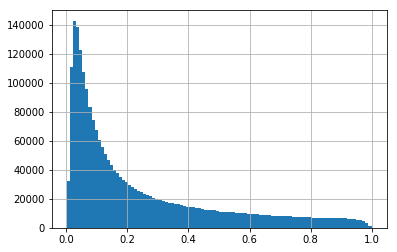

In [43]:
df_sub['is_duplicate'].hist(bins=100)

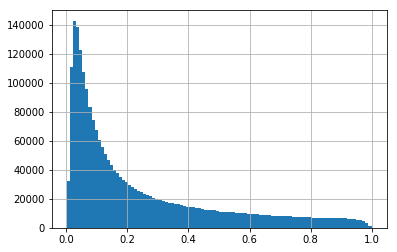

In [44]:
df_sub['is_duplicate'].hist(bins=100)

In [61]:
sub_probe = pd.DataFrame()

sub_probe['test_id'] = df_test.test_id
sub_probe['is_duplicate'] = np.ones(df_test.shape[0]) * 0.7

In [62]:
sub_probe.to_csv('sub_probe_0.7.csv', index=False)

In [ ]:
(-0.50433 - np.log(1 - p)) / (np.log(p / (1 - p)))
(nN * np.log(p / (1 - p))) + (np.log(1 - p))

In [63]:
df_sub.shape

(865, 1)